# 14. 다양한 데이터 전처리 기법


## 1. 들어가며

### 전처리는 왜 중요할까?
---
“데이터 분석의 8할은 데이터 전처리이다.”라는 말이 있다. 왜 데이터 분석에 있어 전처리는 중요한 걸까?

전처리에 따라서 데이터 분석의 질이 달라지기 때문이다. 전처리가 충분히 되어있지 않거나 잘못된 데이터를 사용한 경우 분석 결과의 신뢰도가 떨어지고, 예측 모델의 정확도도 떨어질 것이다. 전처리가 잘 되어 있는 경우 데이터 분석의 질이 높아지고 예측 모델의 성능을 높일 수 있다.

#### 데이터를 준비하자!

터미널을 열어 다음과 같이 작업 디렉토리를 구성하고 데이터를 다운로드받아보자.

[trade.csv](https://aiffelstaticprd.blob.core.windows.net/media/documents/trade.csv)

```bash
$ mkdir -p ~/aiffel/data_preprocess/data
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/trade.csv
$ mv trade.csv ~/aiffel/data_preprocess/data
```

[trade.csv](https://drive.google.com/file/d/1OxbzOGY3OBJK48wYr6CAKS8lAhOn52Il/view)는 [관세청 수출입 무역 통계](https://unipass.customs.go.kr/ets/index.do)에서 가공한 데이터다.

특정 국가에 대한 월별 수출입 건수와 금액(단위:천 불(USD 1,000))이 있다. 무역수지는 수출금액-수입금액이다.

__필요한라이브러리 import__

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os

csv_file_path = os.getenv('HOME')+'/aiffel/data_preprocess/data/trade.csv'
trade = pd.read_csv(csv_file_path) 
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지,기타사항
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0,NaN
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0,NaN
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0,NaN
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0,NaN
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0,NaN


### 학습 목표
---
* 중복된 데이터를 찾아 제거할 수 있고, 결측치(missing data)를 제거하거나 채워 넣을 수 있다.
* 데이터를 정규화시킬 수 있다.
* 이상치(outlier)를 찾고, 이를 처리할 수 있다.
* 범주형 데이터를 원-핫 인코딩할 수 있다.
* 연속적인 데이터를 구간으로 나눠 범주형 데이터로 변환할 수 있다.

### 배울 내용
---
1. 결측치(Missing Data)
2. 중복된 데이터
3. 이상치(Outlier)
4. 정규화(Normalization)
5. 원-핫 인코딩(One-Hot Encoding)
6. 구간화(Binning)

## 2. 결측치(Missing Data)

데이터를 수집하는 과정에서 누락되지 않도록 하는 것이 더 좋은 방법이지만 이미 결측치가 존재한다면 이를 처리해주어야 한다.<br>
결측치를 처리하는 방법은 크게 두 가지가 있다.
1. 결측치가 있는 데이터를 제거한다.
2. 결측치를 어떤 값으로 대체한다. 
    - 결측치를 대체하는 방법은 다양한데 데이터마다 특성을 반영하여 해결해야 한다.

__결측치 여부확인하기.__

In [4]:
print('전체 데이터 건수:', len(trade))

전체 데이터 건수: 199


전체 데이터 건수에서 각 컬럼별 값이 있는 데이터 수를 빼주면 컬럼별 결측치의 개수를 알 수 있다.

In [5]:
print('컬럼별 결측치 개수')
len(trade) - trade.count()

컬럼별 결측치 개수


기간        0
국가명       0
수출건수      3
수출금액      4
수입건수      3
수입금액      3
무역수지      4
기타사항    199
dtype: int64

`'기타사항'`을 보면 전부 결측치라는 것을 알 수 있다. 이는 아무런 정보가 없는 컬럼이므로 삭제하는게 좋다.

In [7]:
trade = trade.drop('기타사항', axis=1)
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0


기타사항 컬럼이 삭제된 것을 확인할 수 있다.

결측치가 있는 행을 살펴보자.

`DataFrame.isnull()`은 데이터마다 결측치 여부를 True, False로 반환한다.<br>
`DataFrame.any(axis=1)`는 행마다 하나라도 True가 있으면 True, 그렇지 않으면 False를 반환한다.

두 메서드를 조합하여 결측치가 하나라도 있는 행을 찾아보자.

DataFrame에 `isnull()`을 적용하고, 여기도 또 `any(axis=1)` 메서드를 적용한다. 이렇게 해면, '각 행이 결측치가 하나라도 있는지' 여부를 불리언 값으로 가진 Series가 출력된다.

In [8]:
trade.isnull()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
194,False,False,False,False,False,False,False
195,False,False,False,False,False,False,False
196,False,False,True,True,True,True,True
197,False,False,True,True,True,True,True


In [9]:
trade.isnull().any(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
194    False
195    False
196     True
197     True
198     True
Length: 199, dtype: bool

`trade.isnull().any(axis=1)` 을 다시 DataFrame에 넣어주면 값이 True인 데이터만 추출해준다.

In [10]:
trade[trade.isnull().any(axis=1)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN
196,2020년 06월,중국,NaN,NaN,NaN,NaN,NaN
197,2020년 06월,미국,NaN,NaN,NaN,NaN,NaN
198,2020년 06월,일본,NaN,NaN,NaN,NaN,NaN


index 191 데이터는 수출금액과 무역수지 컬럼이 빠져있고, index 196, 197, 198은 기간, 국가명을 제외하고 모두 결측치이다.<br>
이 경우 index 191 데이터는 삭제하기보다 특정 값으로 대체하는 것이 좋겠다.<br>
반면 index 196, 197, 198은 제거하는 것이 바람직하다.

* 우선 '수출건수', '수출금액', '수입건수', '수입금액', '무역수지' 열이 모두 결측치인 index 196, 197, 198을 삭제하자<br>
DataFrame의 `dropna`는 결측치를 삭제해주는 메서드다.
    - *`subset` 옵션으로 특정 컬럼들을 선택했다.*
    - `how` 옵션으로 선택한 컬럼 전부가 결측치인 행을 삭제하겠다는 의미로 'all'을 선택한다. <br>
    ('any': 하나라도 결측치인 경우)
    - `inplace` 옵션으로 해당 DataFrame 내부에 바로 적용시킨다.

In [11]:
trade.dropna(how='all', subset=['수출건수', '수출금액', '수입건수', '수입금액', '무역수지'], inplace=True)

In [12]:
trade[trade.isnull().any(axis=1)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN


index 191과 같이 수치형 데이터를 보완할 방법은 많다.

1. 특정 값을 지정해줄 수 있다. 그러나 결측치가 많은 경우, 모두 같은 값으로 대체한다면 데이터의 분산이 실제보다 작아지는 문제가 생길 수 있다.
2. 평균, 중앙값 등으로 대체할 수 있다. 1번에서 특정 값으로 대체했을 때와 마찬가지로 결측치가 많은 경우 데이터의 분산이 실제보다 작아지는 문제가 발생할 수 있다.
3. 다른 데이터를 이용해 예측값으로 대체할 수 있다. 예를 들어 머신러닝 모델로 2020년 4월 미국의 예측값을 만들고, 이 값으로 결측치를 보완할 수 있다.
4. 시계열 특성을 가진 데이터의 경우 앞뒤 데이터를 통해 결측치를 대체할 수 있다. 예를 들어 기온을 측정하는 센서 데이터에서 결측치가 발생할 경우, 전후 데이터의 평균으로 보완할 수 있다.

index 191은 4번 방법을 통해 보완하도록 하자.

DataFrame.loc[행 라벨, 열 라벨]을 입력하면 해당 라벨을 가진 데이터를 출력해준다.

In [13]:
trade.loc[[188, 191, 194]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
188,2020년 03월,미국,97117.0,7292838.0,1368345.0,5388338.0,1904500.0
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN
194,2020년 05월,미국,126598.0,4600726.0,1157163.0,4286873.0,313853.0


index 191의 수출금액 컬럼값을 이전 달과 다음 달의 평균으로 채워보자.

In [14]:
trade.loc[191, '수출금액'] = (trade.loc[188, '수출금액'] + trade.loc[194, '수출금액'] )/2
trade.loc[[191]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,NaN


index 191의 무역수지 컬럼은 수출금액과 수입금액의 차이를 이용하여 채우자.

In [15]:
trade.loc[191, '무역수지'] = trade.loc[191, '수출금액'] - trade.loc[191, '수입금액'] 
trade.loc[[191]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0


지금까지 데이터가 수치형인 경우 결측치를 삭제하거나 대체하는 방법이었다.<br>
데이터가 범주형인 경우는 어떻게 해야 할까? 이는 수치형일 때와 유사하다.

1. 특정 값을 지정해줄 수 있다. 예를 들어 ‘기타’, ‘결측’과 같이 새로운 범주를 만들어 결측치를 채울 수 있다.
2. 최빈값 등으로 대체한다. 결측치가 많은 경우 최빈값이 지나치게 많아질 수 있으므로 결측치가 많을 때는 다른 방법을 사용한다.
3. 다른 데이터를 이용해 예측값으로 대체할 수 있다.
4. 시계열 특성을 가진 데이터의 경우 앞뒤 데이터를 통해 결측치를 대체할 수 있다. 예를 들어 특정인의 2019년 직업이 결측치이고, 2018년과 2020년 직업이 일치한다면 그 값으로 보완할 수 있다. 만약 다르다면 둘 중 하나로 보완하면 된다.

## 3. 중복된 데이터

데이터를 수집하는 과정에서 중복된 데이터가 생길 수 있다. 같은 값을 가진 데이터 없이 행(row)별로 값이 유일해야 한다면 중복된 데이터를 제거해야 한다.

우선 중복된 데이터를 확인해보자.<br>
`DataFrame.duplicated()`는 중복된 데이터 여부를 불리언 값으로 반환해준다.

In [16]:
trade.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
191    False
192    False
193    False
194    False
195    False
Length: 196, dtype: bool

In [17]:
trade[trade.duplicated()]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
187,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0


In [18]:
trade[(trade['기간']=='2020년 03월')&(trade['국가명']=='중국')]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
186,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0
187,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0


index 186, 187이 중복되어 있다.

pandas에서는 `DataFrame.drop_duplicates`를 통해 중복된 데이터를 쉽게 삭제할 수 있다.

In [19]:
trade.drop_duplicates(inplace=True)

`DataFrame.drop_duplicates`를 좀 더 자세히 살펴보자

다음과 같이 id와 name을 컬럼으로 갖는 df가 있다.

In [20]:
df = pd.DataFrame({'id':['001', '002', '003', '004', '002'], 
                   'name':['Park Yun', 'Kim Sung', 'Park Jin', 'Lee Han', 'Kim Min']})
df

,id,name
0,001,Park Yun
1,002,Kim Sung
2,003,Park Jin
3,004,Lee Han
4,002,Kim Min


id가 002인 데이터가 2개 있다. id가 사람마다 unique 하다고 할 때, 둘 중 하나는 삭제해야 한다.<br>
index가 클수록 나중에 들어온 데이터이고, 사용자가 이름을 수정했을 때 업데이트가 되지 않고 삽입이 되어 생긴 문제라고 가정해보자.<br>
즉, id가 중복된 경우 맨 나중에 들어온 값만 남겨야 한다.<br>
`DataFrame.drop_duplicates`의 `subset`, `keep` 옵션을 통해 손쉽게 중복을 제거할 수 있다.

추가 설명 : [DataFrame.drop_duplicates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

In [21]:
df.drop_duplicates(subset=['id'], keep='last')

,id,name
0,001,Park Yun
2,003,Park Jin
3,004,Lee Han
4,002,Kim Min


## 4. 이상치(Outlier)

trade 데이터에서 큰 값을 가지는 이상치가 있다고 가정해보자.<br>
이상치란 대부분 값의 범위에서 벗어나 극단적으로 크거나 작은 값을 의미한다.

Min-Max Scaling 해보면 대부분의 값은 0에 가깝고 이상치만 1에 가까운 값을 가지게 될 것이다. 이렇게 몇 개의 이상치 때문에 대부분 값의 차이는 의미가 거의 없어지게 된다.<br>
극단적인 값이 생기는 경우를 제외하고 데이터를 고려하고 싶은 경우 이상치를 제거하고 분석한다.

그렇다면 이상치를 어떻게 찾아내야 할까?

가장 먼저 생각해 볼 수 있는 간단하고 자주 사용되는 방법은 평균과 표준편차를 이용하는 `z score` 방법이다.<br>
평균을 빼주고 표준편차로 나눠 `z score`(${\frac {X-\mu }{\sigma }}$)를 계산한다. 그리고 `z score`가 특정 기준을 넘어서는 데이터에 대해 이상치라고 판단한다. 기준을 작게 하면 이상치라고 판단하는 데이터가 많아지고, 기준을 크게 하면 이상치라고 판단하는 데이터가 적어진다.

이상치를 판단한 뒤 어떻게 해야 할까??

1. 가장 간단한 방법으로 이상치를 삭제하는 방법이 있다. 이상치를 원래 데이터에서 삭제하고, 이상치끼리 따로 분석하는 방안도 있다.
2. 이상치를 다른 값으로 대체할 수 있다. 데이터가 적으면 이상치를 삭제하기보다 다른 값으로 대체하는 것이 나을 수 있다. 예를 들어 최댓값, 최솟값을 설정해 데이터의 범위를 제한할 수 있다.
3. 혹은 결측치와 마찬가지로 다른 데이터를 활용하여 예측 모델을 만들어 예측값을 활용할 수도 있다.
4. 아니면 binning을 통해 수치형 데이터를 범주형으로 바꿀 수도 있다.


### z-score method
---
이상치인 데이터의 인덱스를 리턴하는 `outlier`라는 함수를 만들어보자.<br>
데이터프레임 `df`, 컬럼 `col`, 기준 `z`를 인풋으로 받는다.

`abs(df[col] - np.mean(df[col]))` : 데이터에서 평균을 빼준 것에 절대값을 취한다.<br>
`abs(df[col] - np.mean(df[col]))/np.std(df[col])` : 위에 한 작업에 표준편차로 나눠준다.<br>
`df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index`: 값이 z보다 큰 데이터의 인덱스를 추출한다.

In [22]:
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index

In [23]:
trade.loc[outlier(trade, '무역수지', 1.5)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
6,2015년 03월,중국,117529.0,11868032.0,234321.0,7226911.0,4641121.0
75,2017년 02월,중국,159062.0,11118131.0,188555.0,6600637.0,4517495.0
80,2017년 03월,일본,65093.0,2395932.0,165734.0,5157589.0,-2761657.0
96,2017년 09월,중국,183442.0,13540683.0,295443.0,8443414.0,5097269.0
99,2017년 10월,중국,137873.0,12580474.0,244977.0,7932403.0,4648071.0
101,2017년 10월,일본,63510.0,1847999.0,127696.0,4418583.0,-2570584.0
102,2017년 11월,중국,421194.0,14000887.0,307790.0,9253318.0,4747569.0
105,2017년 12월,중국,218114.0,13848364.0,290347.0,8600132.0,5248232.0
114,2018년 03월,중국,232396.0,13576667.0,267249.0,8412516.0,5164151.0
116,2018년 03월,일본,80142.0,2603450.0,159601.0,5226141.0,-2622691.0


In [24]:
trade.loc[outlier(trade, '무역수지', 2)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
129,2018년 08월,중국,199010.0,14401521.0,280033.0,8525532.0,5875989.0
132,2018년 09월,중국,171328.0,14590529.0,280337.0,7889890.0,6700639.0


In [25]:
trade.loc[outlier(trade, '무역수지', 3)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지


무역수지의 이상치를 확인하는데 기준 되는 값이 클수록 이상치가 적어지는 것을 확인할 수 있다.

이제 not_outlier라는 함수를 통해 무역수지가 이상치 값이 아닌 데이터만 추출하도록 하자.

In [26]:
def not_outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col]) <= z].index

In [27]:
trade.loc[not_outlier(trade, '무역수지', 1.5)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0
...,...,...,...,...,...,...,...
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0
192,2020년 04월,일본,134118.0,1989323.0,141207.0,3989562.0,-2000239.0
193,2020년 05월,중국,185320.0,10746069.0,349007.0,8989920.0,1756149.0
194,2020년 05월,미국,126598.0,4600726.0,1157163.0,4286873.0,313853.0


### IQR method
---
이상치를 찾는 방법에는 위에 설명한 z-score 방법만 있는 것은 아니다. 그리고 z-score 방법은 몇 가지 뚜렷한 한계점을 가지고 있다.

z-score 방법의 대안으로 사분위범위수 IQR(Interquartile range) 로 이상치를 알아내는 방법을 알아보자.

이해를 돕기 위해 아웃라이어가 포함된 임의의 데이터를 만들어보겠다.

In [28]:
np.random.seed(2020)
data = np.random.randn(100)  # 평균 0, 표준편차 1의 분포에서 100개의 숫자를 샘플링한 데이터 생성
data = np.concatenate((data, np.array([8, 10, -3, -5])))      # [8, 10, -3, -5])를 데이터 뒤에 추가함
data

array([-1.76884571,  0.07555227, -1.1306297 , -0.65143017, -0.89311563,
       -1.27410098, -0.06115443,  0.06451384,  0.41011295, -0.57288249,
       -0.80133362,  1.31203519,  1.27469887, -1.2143576 ,  0.31371941,
       -1.44482142, -0.3689613 , -0.76922658,  0.3926161 ,  0.05729383,
        2.08997884,  0.04197131, -0.04834072, -0.51315392, -0.08458928,
       -1.21545008, -1.41293073, -1.48691055,  0.38222486,  0.937673  ,
        1.77267804,  0.87882801,  0.33171912, -0.30603567,  1.24026615,
       -0.21562684,  0.15592948,  0.09805553,  0.83209585,  2.04520542,
       -0.31681392, -1.31283291, -1.75445746,  0.10209408, -1.36150208,
        0.48178488, -0.20832874, -0.09186351,  0.70268816,  0.10365506,
        0.62123638,  0.95411497,  2.03781352, -0.48445122,  0.2071549 ,
        1.64424216, -0.4882074 , -0.01782826,  0.46891556,  0.27987266,
       -0.64664972, -0.54406002, -0.16008985,  0.03781172,  1.03383296,
       -1.23096117, -1.24673665,  0.29572055,  2.1409624 , -0.92

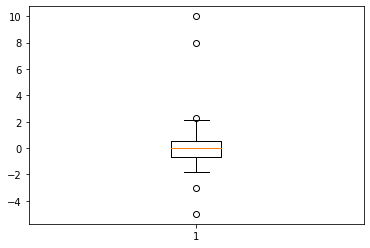

In [29]:
fig, ax = plt.subplots()
ax.boxplot(data)
plt.show()

박스 플롯에서 박스를 벗어난 점들이 보인다.

우리는 사분위범위수 IQR(Interquartile range)을 이용하여 이상치를 찾아낼 수 있다.

$IQR = Q_{3} - Q_{1}$ <br>
즉, IQR은 제 3사분위수에서 제 1사분위 값을 뺀 값으로 데이터의 중간 50%의 범위라고 생각하시면 된다.<br>
$Q_{1} - 1.5*IQR$ 보다 왼쪽에 있거나 $Q_{3} + 1.5*IQR$보다 오른쪽에 있는 경우 우리는 이상치라고 판단한다.

아래 그림을 보면 이 식의 의미가 좀 더 이해가 될것이다.

<img src="./image/iqr.jpg" />
<center>[출처 : https://en.wikipedia.org/wiki/Interquartile_range]</center>

IQR을 구하기 위해 우선 제1사분위수와 제 3사분위수를 구한다.

In [30]:
Q3, Q1 = np.percentile(data, [75 ,25])
IQR = Q3 - Q1
IQR

1.1644925829790964

IQR과 제 1사분위수, 제 3사분위수를 이용하여 이상치를 확인할 수 있다.

In [31]:
data[(Q1-1.5*IQR > data)|(Q3+1.5*IQR < data)]

array([ 2.31256634,  8.        , 10.        , -3.        , -5.        ])

위에서 z-score 방법과 IQR 방법에 대해서 알아보았다. 그럼 다음 링크의 아티클을 읽어보고 질문에 답해보자.

* [Three ways to detect outliers](http://colingorrie.github.io/outlier-detection.html)

__z-score 방법이 가지는 뚜렷한 단점 2가지__

1) Robust하지 못하다 <br>
- 왜나하면 평균과 표준편차 자체가 이상치의 존재에 크게 영향을 받기 때문이다.

2) 작은 데이터셋의 경우 z-score의 방법으로 이상치를 알아내기 어렵다. 특히 item이 12개 이하인 데이터셋에서는 불가능하다.

무역수지를 기준으로 이상치를 찾아보자.

In [33]:
def outlier2(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    return df[(df[col] < q1-1.5*iqr)|(df[col] > q3+1.5*iqr)]

outlier2(trade, '무역수지')

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지


## 5. 정규화(Normalization)
trade 데이터를 보면 수입건수, 수출건수와 수입금액, 수출금액, 무역수지는 단위가 다르다는 것을 알 수 있다.

이처럼 컬럼마다 스케일이 크게 차이가 나는 데이터를 입력하면 머신러닝 모델 학습에 문제가 발생할 수 있다.<br>
예를 들어 데이터의 범위가 0에서 1 사이인 컬럼 A과 1000에서 10000 사이인 컬럼 B이 있다고 생각해보자. 이런 데이터를 클러스터링한다고 가정해보자. 데이터 간의 거리를 잴 때, 범위가 큰 컬럼 B의 값에만 영향을 크게 받을 것이다.<br>
다른 예시로 간단한 linear regression을 한다고 가정해보자. 모델의 파라미터를 업데이트하는 과정에서 범위가 큰 컬럼 B의 파라메터만 집중적으로 업데이트하는 문제가 생길 수 있다.

그래서 일반적으로 컬럼간에 범위가 크게 다를 경우 전처리 과정에서 데이터를 정규화한다.

정규화를 하는 방법은 다양하지만, 가장 잘 알려진 표준화(Standardization)와 Min-Max Scaling을 알아보자.

__Standardization__ 데이터의 평균은 0, 분산은 1로 변환<BR>
$\frac{x - \mu}{\sigma }$<br>
    
__Min-Max Scaling__ 데이터의 최솟값은 0, 최댓값은 1로 변환<BR>

$\frac{x - x_{min}}{x_{max} - x_{min}}$<br>
    
정규화 기법이 데이터의 분포를 어떻게 바꾸는지 살펴보자. 우선 임의의 데이터를 생성하고, 각각의 기법으로 데이터를 정규화시켜주자.

In [34]:
# 정규분포를 따라 랜덤하게 데이터 x를 생성합니다. 
np.random.seed(2020)
x = pd.DataFrame({'A': np.random.randn(100)*4+4,
                 'B': np.random.randn(100)-1})
x

,A,B
0,-3.075383,-0.448552
1,4.302209,-2.151012
2,-0.522519,-1.245304
3,1.394279,-1.169169
4,0.427537,-0.458080
...,...,...
95,13.250265,-0.734271
96,0.137697,-2.041710
97,2.614901,-3.057545
98,7.866735,-2.140529


In [35]:
# 데이터 x를 Standardization 기법으로 정규화합니다. 
x_standardization = (x - x.mean())/x.std()
x_standardization

,A,B
0,-1.862058,0.559307
1,0.072383,-1.132240
2,-1.192684,-0.232338
3,-0.690090,-0.156691
4,-0.943575,0.549839
...,...,...
95,2.418607,0.275419
96,-1.019573,-1.023639
97,-0.370038,-2.032961
98,1.007019,-1.121824


In [36]:
# 데이터 x를 min-max scaling 기법으로 정규화합니다. 
x_min_max = (x-x.min())/(x.max()-x.min())
x_min_max

,A,B
0,0.012283,0.607216
1,0.458634,0.267692
2,0.166733,0.448318
3,0.282702,0.463502
4,0.224213,0.605316
...,...,...
95,1.000000,0.550235
96,0.206677,0.289490
97,0.356550,0.086901
98,0.674291,0.269782


## 6. 원-핫 인코딩(One-Hot Encoding)

이제 범주형 데이터인 국가명 컬럼을 다뤄보도록 하겠다.

머신러닝이나 딥러닝 프레임워크에서 범주형을 지원하지 않는 경우 원-핫 인코딩을 해야 한다. 지난번 포켓몬 데이터를 다루면서 원-핫 인코딩에 대한 개념을 익혔다.

원-핫 인코딩이란 무엇인가?

원-핫 인코딩이란 카테고리별 이진 특성을 만들어 해당하는 특성만 1 나머지는 0으로 만드는 방법이다. 그럼, pandas로 국가명 컬럼을 원-핫 인코딩을 해보겠다.

pandas에서 `get_dummies` 함수를 통해 손쉽게 원-핫 인코딩을 할 수 있다.

In [ ]:
#trade 데이터의 국가명 컬럼 원본
print(trade['국가명'].head())  

# get_dummies를 통해 국가명 원-핫 인코딩
country = pd.get_dummies(trade['국가명'])
country.head()

`pd.concat` 함수로 데이터프레임 trade와 country를 합쳐준다.

In [ ]:
trade = pd.concat([trade, country], axis=1)
trade.head()

이제는 필요 없어진 국가명 컬럼을 삭제해주고 나면 trade는 우리가 원하는 데이터프레임이 된다.

In [ ]:
trade.drop(['국가명'], axis=1, inplace=True)
trade.head()

## 7. 구간화(Binning)

지금까지 trade 데이터를 다루면서 다양 전처리 기법을 배웠다. 이제 다른 전처리 기법을 배워보도록 하겠다.

salary에 소득 데이터가 있다고 하자.

In [3]:
salary = pd.Series([4300, 8370, 1750, 3830, 1840, 4220, 3020, 2290, 4740, 4600, 
                    2860, 3400, 4800, 4470, 2440, 4530, 4850, 4850, 4760, 4500, 
                    4640, 3000, 1880, 4880, 2240, 4750, 2750, 2810, 3100, 4290, 
                    1540, 2870, 1780, 4670, 4150, 2010, 3580, 1610, 2930, 4300, 
                    2740, 1680, 3490, 4350, 1680, 6420, 8740, 8980, 9080, 3990, 
                    4960, 3700, 9600, 9330, 5600, 4100, 1770, 8280, 3120, 1950, 
                    4210, 2020, 3820, 3170, 6330, 2570, 6940, 8610, 5060, 6370,
                    9080, 3760, 8060, 2500, 4660, 1770, 9220, 3380, 2490, 3450, 
                    1960, 7210, 5810, 9450, 8910, 3470, 7350, 8410, 7520, 9610, 
                    5150, 2630, 5610, 2750, 7050, 3350, 9450, 7140, 4170, 3090])

이 데이터를 구간별로 나누고자 한다. 이러한 기법을 구간화(`Data binning` 혹은 `bucketing`)이라고 부른다.

아래 히스토그램과 같이 연속적인 데이터를 구간을 나눠 분석할 때 사용하는 방법이다.

<AxesSubplot:>

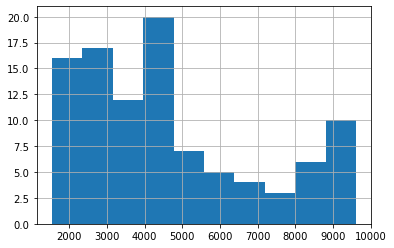

In [4]:
salary.hist()

pandas의 `cut` 과 `qcut`을 이용해 수치형 데이터를 범주형 데이터로 변형시키도록 하겠다.

`cut`을 사용하기 위해 우선 구간을 정해준다.

In [5]:
bins = [0, 2000, 4000, 6000, 8000, 10000]

cut 함수에 데이터와 구간을 입력하면 데이터를 구간별로 나눠준다.

In [6]:
ctg = pd.cut(salary, bins=bins)
ctg

0      (4000, 6000]
1     (8000, 10000]
2         (0, 2000]
3      (2000, 4000]
4         (0, 2000]
          ...      
95     (2000, 4000]
96    (8000, 10000]
97     (6000, 8000]
98     (4000, 6000]
99     (2000, 4000]
Length: 100, dtype: category
Categories (5, interval[int64]): [(0, 2000] < (2000, 4000] < (4000, 6000] < (6000, 8000] < (8000, 10000]]

`salary[0]`는 4300으로 4000에서 6000 사이에 포함되었다는 것을 확인할 수 있다.

In [7]:
print('salary[0]:', salary[0])
print('salary[0]가 속한 카테고리:', ctg[0])

salary[0]: 4300
salary[0]가 속한 카테고리: (4000, 6000]


구간별로 값이 몇 개가 속해 있는지 `value_counts()`로 확인해보겠다.

In [8]:
ctg.value_counts().sort_index()

(0, 2000]        12
(2000, 4000]     34
(4000, 6000]     29
(6000, 8000]      9
(8000, 10000]    16
dtype: int64

이렇게 특정 구간을 지정해줘도 되고, 구간의 개수를 지정해줄 수도 있다. `bins` 옵션에 정수를 입력하면 데이터의 최솟값에서 최댓값을 균등하게 `bins` 개수만큼 나눠준다.

In [9]:
ctg = pd.cut(salary, bins=6)
ctg

0      (4230.0, 5575.0]
1      (8265.0, 9610.0]
2     (1531.93, 2885.0]
3      (2885.0, 4230.0]
4     (1531.93, 2885.0]
            ...        
95     (2885.0, 4230.0]
96     (8265.0, 9610.0]
97     (6920.0, 8265.0]
98     (2885.0, 4230.0]
99     (2885.0, 4230.0]
Length: 100, dtype: category
Categories (6, interval[float64]): [(1531.93, 2885.0] < (2885.0, 4230.0] < (4230.0, 5575.0] < (5575.0, 6920.0] < (6920.0, 8265.0] < (8265.0, 9610.0]]

In [10]:
ctg.value_counts().sort_index()

(1531.93, 2885.0]    27
(2885.0, 4230.0]     24
(4230.0, 5575.0]     21
(5575.0, 6920.0]      6
(6920.0, 8265.0]      7
(8265.0, 9610.0]     15
dtype: int64

`qcut`은 구간을 일정하게 나누는 것이 아니라 데이터의 분포를 비슷한 크기의 그룹으로 나눠준다.

In [11]:
ctg = pd.qcut(salary, q=5)
ctg

0       (3544.0, 4648.0]
1       (7068.0, 9610.0]
2     (1539.999, 2618.0]
3       (3544.0, 4648.0]
4     (1539.999, 2618.0]
             ...        
95      (2618.0, 3544.0]
96      (7068.0, 9610.0]
97      (7068.0, 9610.0]
98      (3544.0, 4648.0]
99      (2618.0, 3544.0]
Length: 100, dtype: category
Categories (5, interval[float64]): [(1539.999, 2618.0] < (2618.0, 3544.0] < (3544.0, 4648.0] < (4648.0, 7068.0] < (7068.0, 9610.0]]

In [12]:
print(ctg.value_counts().sort_index())

(1539.999, 2618.0]    20
(2618.0, 3544.0]      20
(3544.0, 4648.0]      20
(4648.0, 7068.0]      20
(7068.0, 9610.0]      20
dtype: int64


### **마무리와 복습 과제**

---

현실에서 여러분이 만날 데이터는 깨끗하지 않은 경우가 많다. 그래서 오늘은 표 데이터 전처리하는 방법을 배웠다. 어떤 내용을 다뤘는지 키워드로 살펴보겠다.

* 결측치(Missing Data)
* 중복된 데이터
* 이상치(Outlier)
* 정규화(Normalization)
* 원-핫 인코딩(One-Hot Encoding)
* 구간화(Binning)

위의 내용을 배웠지만 모든 데이터에 일괄적으로 적용해야 하는 것은 아니다.<br>
데이터 전처리는 데이터의 특성을 파악해서 해야 한다.

그래서 다소 번거롭게 느껴질 수 있지만 꼭 해야 하는 과정인 만큼 복습해보기를 권한다. 남는 시간 동안 아래 데이터셋의 전처리 과정을 진행해보자.

* [vgsales.csv](https://aiffelstaticprd.blob.core.windows.net/media/documents/vgsales.csv)

위 데이터의 출처는 캐글의 [Video Game Sales](https://www.kaggle.com/gregorut/videogamesales) 데이터셋이다. 16,500개 이상의 비디오 게임에 대한 매출 정보 등이 담겨 있다. 위에 언급된 전처리 기법 중 다수를 시도해 볼 수 있는 데이터셋이므로, 오늘 배운 기법들이 본인의 것이 될 수 있도록 복습을 통해 다시 한번 개념을 다져보기를 권한다.

이외에도 표 데이터를 직접 전처리해 보면 더욱 흥미롭게 할 수 있다. 데이터가 없다면 [공공데이터포털](https://www.data.go.kr/), [캐글](https://www.kaggle.com/)에서 관심 있는 분야의 데이터를 찾아보길 바란다.